<a href="https://colab.research.google.com/github/jinrumiao/titanic-analysis/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C_01%EF%BC%9A%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 鐵達尼號存活預測

## 套件載入

In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use("ggplot")
sns.set_style("white")
matplotlib.rcParams["figure.figsize"] = 8, 6

## functions設定

In [82]:
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get("row", None)
    col = kwargs.get("col", None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, fill=True)
    facet.set(xlim=(0, df[var].max()))
    facet.add_legend()


def plot_catecories(df, cat, target, **kwargs):
    row = kwargs.get("row", None)
    col = kwargs.get("col", None)
    facet = sns.FacetGrid(df, row=row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()


def clean_ticket(ticket):
    ticket = ticket.replace(".", "").replace("/", "")
    ticket = ticket.split()
    ticket = map(lambda t: t.strip(), ticket)
    ticket = list(filter(lambda t: not t.isdigit(), ticket))

    if len(ticket) > 0:
        return ticket[0]
    else:
        return "XXX"

## 資料處理

In [83]:
# 載入csv
df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


### 處理離散型資料

In [84]:
# 1、Name中間包含頭銜，又代表社會地位，可能會與是否生存有關
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Dr": "Officer",
    "Rev": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Dona": "Royalty",
    "Lady": "Royalty",
    "the Countess": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
}
df["Title"] = df["Name"].map(lambda name: name.split(", ")[1].split(".")[0].strip())
df["Title"] = df["Title"].map(title_dictionary)

title_one_hot_ec = pd.get_dummies(df["Title"], prefix="Title", dtype=int)
df = pd.concat([df, title_one_hot_ec], axis=1)

In [85]:
# 2、Sex
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

In [86]:
# 3、Ticket
df["Ticket_cat"] = df["Ticket"].map(clean_ticket)

ticket_one_hot_ec = pd.get_dummies(df["Ticket_cat"], prefix="Ticket", dtype=int)
df = pd.concat([df, ticket_one_hot_ec], axis=1)

In [87]:
# 4、Cabin 204/891
df["Cabin"] = df["Cabin"].fillna("U")
df["Cabin"] = df["Cabin"].astype(str).map(lambda c: c[0])

cabin_one_hot_ec = pd.get_dummies(df["Cabin"], prefix="Cabin", dtype=int)
df = pd.concat([df, cabin_one_hot_ec], axis=1)

In [88]:
# 5、Embarked 889/891
df["Embarked"] = df["Embarked"].fillna("U")

embarked_one_hot_ec = pd.get_dummies(df["Embarked"], prefix="Embarked", dtype=int)
df = pd.concat([df, embarked_one_hot_ec], axis=1)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 64 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    int64  
 5   Age             714 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           891 non-null    object 
 11  Embarked        891 non-null    object 
 12  Title           891 non-null    object 
 13  Title_Master    891 non-null    int64  
 14  Title_Miss      891 non-null    int64  
 15  Title_Mr        891 non-null    int64  
 16  Title_Mrs       891 non-null    int64  
 17  Title_Officer   891 non-null    int

Using the barplot function without specifying `order` is likely to produce an incorrect plot.
Using the barplot function without specifying `order` is likely to produce an incorrect plot.
Using the barplot function without specifying `order` is likely to produce an incorrect plot.
Using the barplot function without specifying `order` is likely to produce an incorrect plot.
Using the barplot function without specifying `order` is likely to produce an incorrect plot.


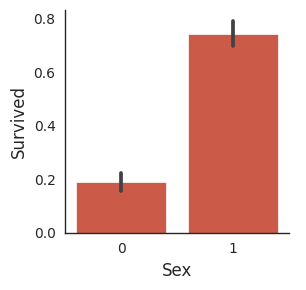

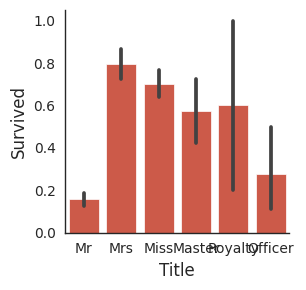

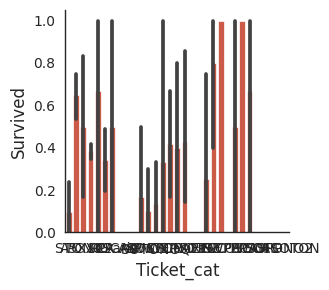

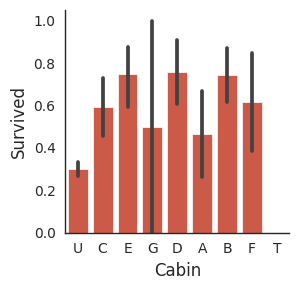

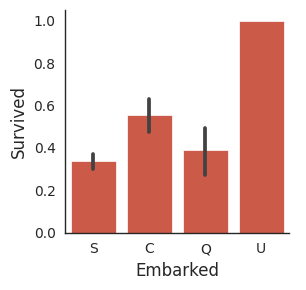

In [90]:
plot_catecories(df, cat="Sex", target="Survived")  # 繪出Sex與Survived的關係，女性的生存率遠高於男性
plot_catecories(df, cat="Title", target="Survived")  # 繪出Title與Survived的關係，Mrs與Miss為生存率最高的兩個分類
plot_catecories(df, cat="Ticket_cat", target="Survived")  # 繪出Ticket與Survived的關係，Ticket與生存率並無明顯關係
plot_catecories(df, cat="Cabin", target="Survived")  # 繪出Cabin與Survived的關係，Cabin與生存率並無明顯關係
plot_catecories(df, cat="Embarked", target="Survived")  # 繪出Embarked與Survived的關係，扣除無資料的乘客，C點登船的乘客有較高的生存率

plt.show()

### 處理連續型資料



*   其中Age的空值有使用mean以及median比較，兩者的最終成果無太大差異
*   Pclass也有測試改用one_hot_encoder的形式，結果也與原本的label_encoder無差異





In [91]:
# 1、Pclass、Age、Fare
df["Age"].fillna(df["Age"].mean(), inplace=True)

normalize_columns = ["Pclass", "Age", "Fare"]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[normalize_columns])
normalized_df = pd.DataFrame(normalized_data, columns=normalize_columns)

df[normalize_columns] = normalized_df

In [92]:
# 2、SibSp、Parch
df["Family_size"] = df["SibSp"] + df["Parch"] + 1

df["Family_Single"] = df["Family_size"].map(lambda s: 1 if s == 1 else 0)
df["Family_Small"] = df["Family_size"].map(lambda s: 1 if 2 <= s <= 4 else 0)
df["Family_Large"] = df["Family_size"].map(lambda s: 1 if 5 <= s else 0)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    float64
 3   Name            891 non-null    object 
 4   Sex             891 non-null    int64  
 5   Age             891 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           891 non-null    object 
 11  Embarked        891 non-null    object 
 12  Title           891 non-null    object 
 13  Title_Master    891 non-null    int64  
 14  Title_Miss      891 non-null    int64  
 15  Title_Mr        891 non-null    int64  
 16  Title_Mrs       891 non-null    int64  
 17  Title_Officer   891 non-null    int

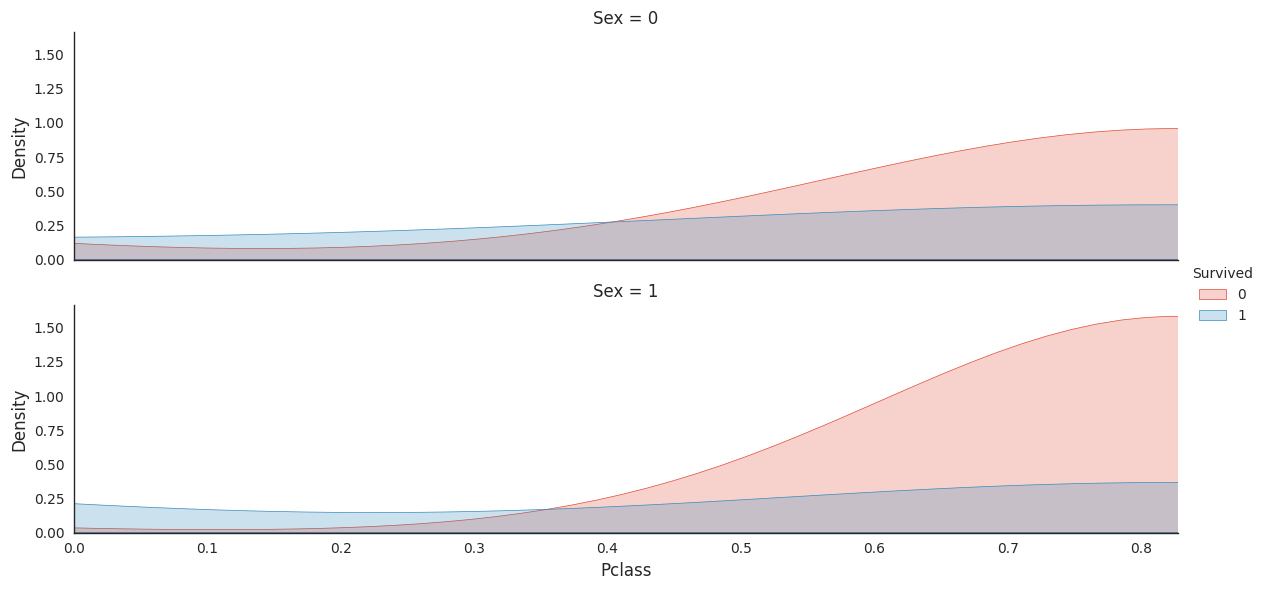

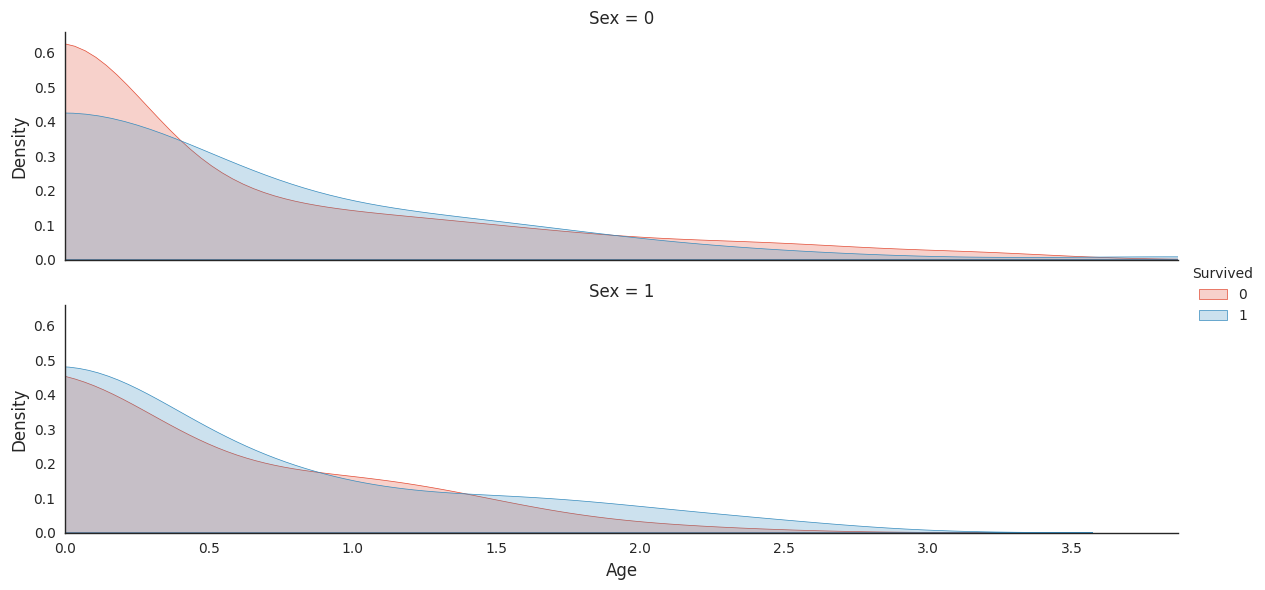

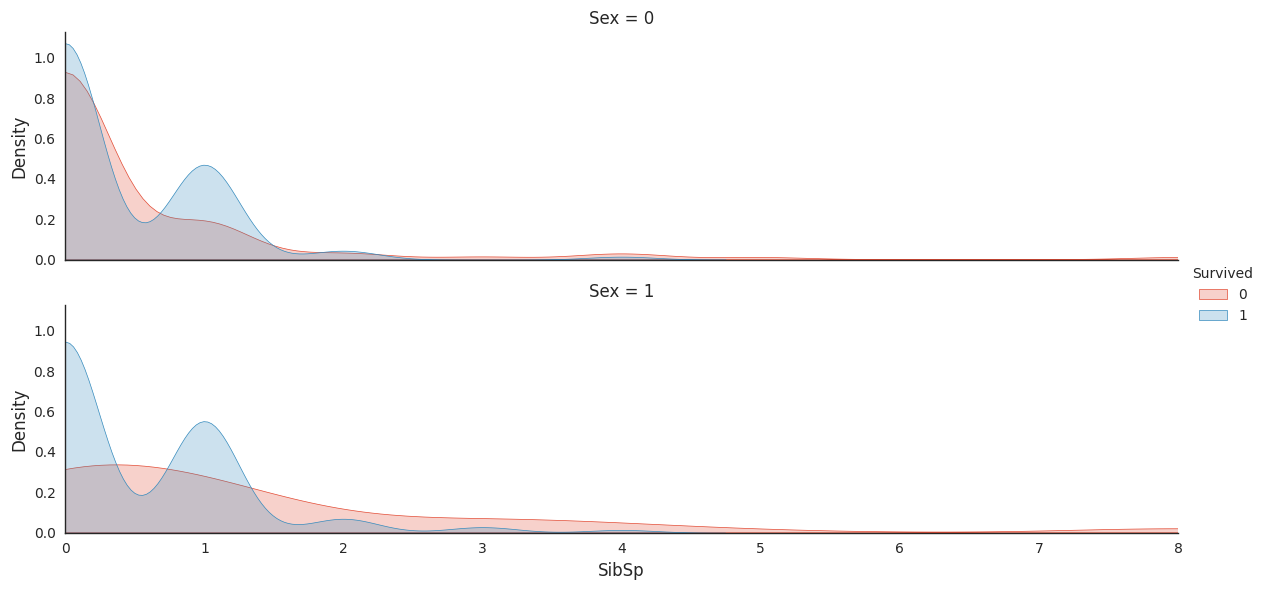

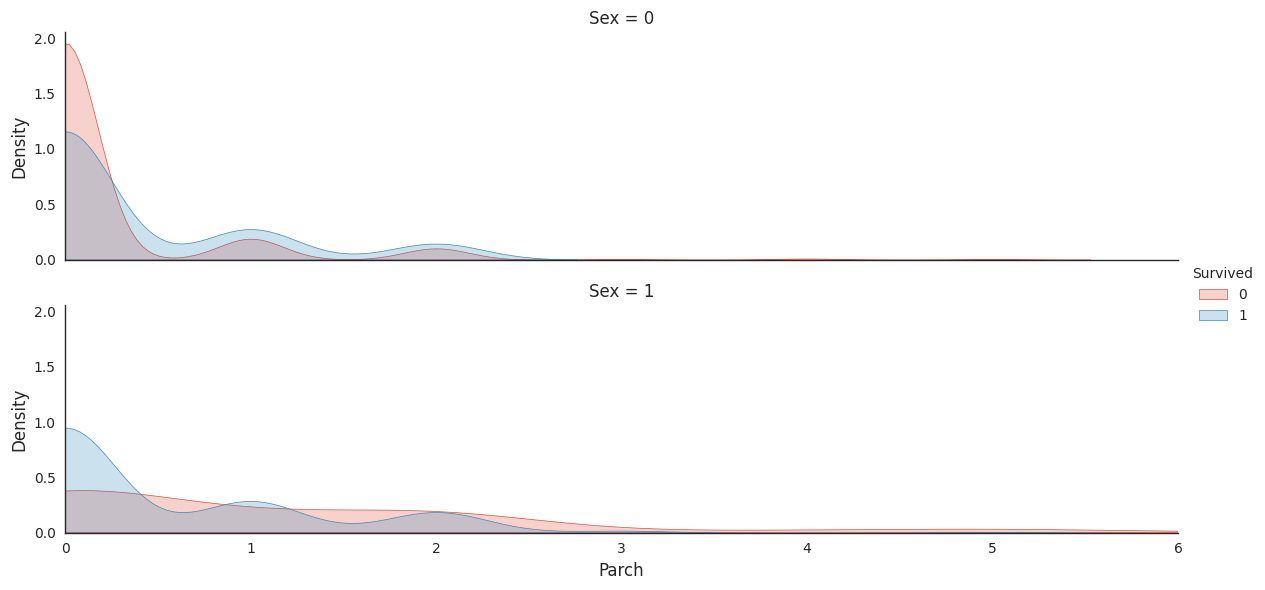

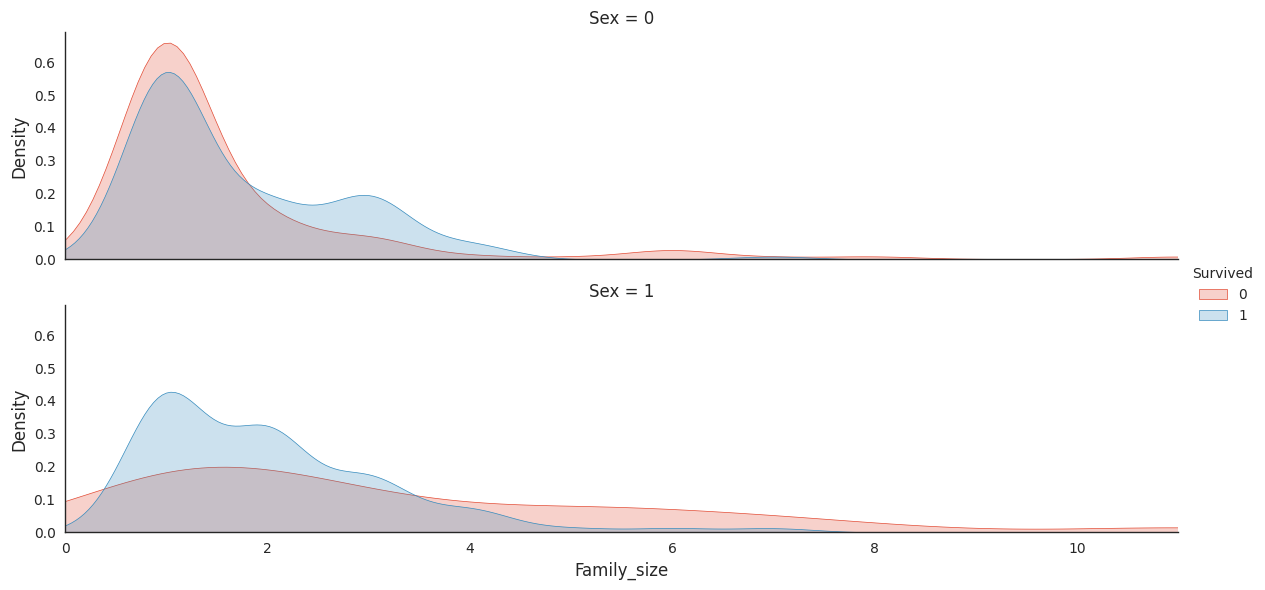

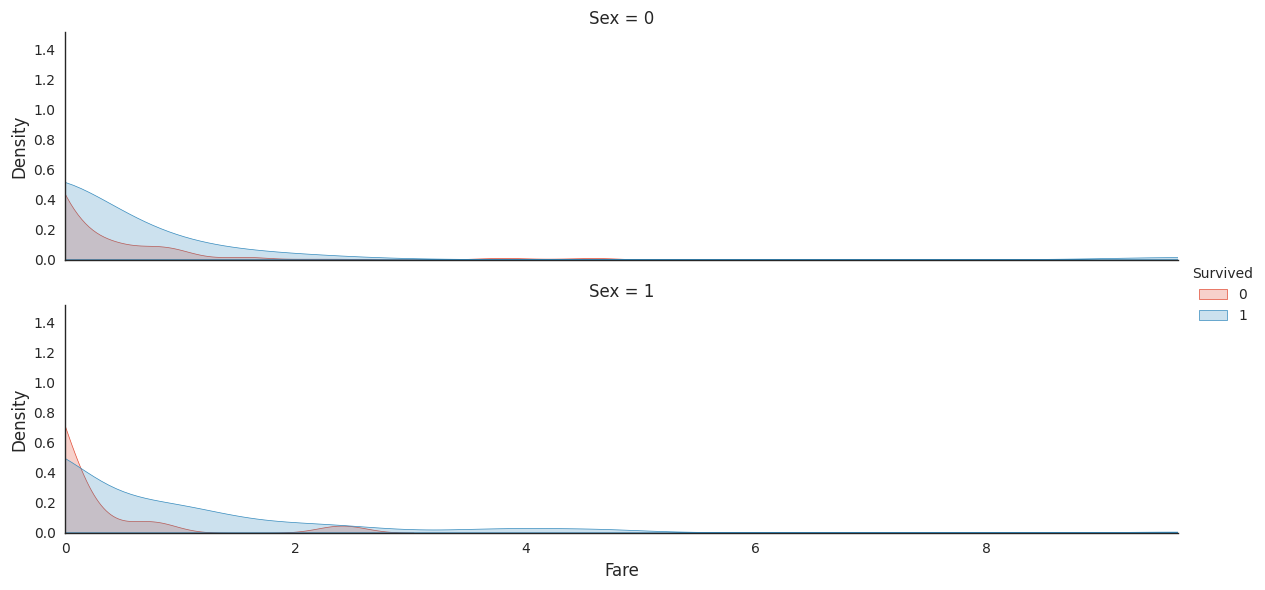

In [94]:
plot_distribution(df, var="Pclass", target="Survived", row="Sex")  # 繪出Pclass與Survived的關係，Pclass 3的乘客的生存率較低
plot_distribution(df, var="Age", target="Survived", row="Sex")  # 繪出Age與Survived的關係，Age與是否生存的關係較不明顯
plot_distribution(df, var="SibSp", target="Survived", row="Sex")  # 繪出SibSp與Survived的關係，沒有與手足一起登船的乘客占大多數
plot_distribution(df, var="Parch", target="Survived", row="Sex")  # 繪出SibSp與Survived的關係，沒有與父母或子女一起登船的乘客占大多數
plot_distribution(df, var="Family_size", target="Survived", row="Sex")  # 繪出Family_size與Survived的關係，沒有與父母或子女一起登船的乘客占大多數
plot_distribution(df, var="Fare", target="Survived", row="Sex")  # 繪出Fare與Survived的關係，票價與是否生存較無關係

plt.show()

In [95]:
# 整理Dataset內容，將沒有特別意義的或已處理過的資料去除
df.drop(columns=["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin", "Embarked", "Title", "Ticket_cat", "Family_size"],
    axis=1, inplace=True, errors="ignore")

In [96]:
df_train = df.copy()

columns_X = set(df_train.columns) - {'Survived'}
columns_y = ['Survived']

dataset_X = df_train[list(columns_X)]
dataset_y = df_train[columns_y]

### 邏輯回歸預測

In [97]:
log = LogisticRegression(random_state=0, max_iter=3000)

scores = cross_val_score(log, dataset_X, dataset_y.values.ravel(), cv=5, scoring='accuracy')
print(scores)
print(scores.mean())

[0.81564246 0.81460674 0.81460674 0.8258427  0.85955056]
0.8260498399347185


## Explainable AI SHAP

In [98]:
!pip install shap -q

In [99]:
import shap
shap.initjs()

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(712, 57)
(179, 57)
(712, 1)
(179, 1)


In [101]:
log.fit(X_train, y_train)

pred = log.predict(X_test)

print(pred)

[1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1
 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1
 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [102]:
explainer = shap.explainers.Linear(log, X_train)

shap_values = explainer(X_train)

### Global interpretability

●蜂群圖，一種用來顯示資料集中的特徵對輸出的影響，越上方的特徵代表對輸出的影響性越大，特徵的排序是由該特徵的所以shap_value的絕對值得平均大小決定

點的顏色: Feature value 的大小，越紅越大、越藍越小

X 軸: 該點對於 shap value 的影響，也就是對預測值的影響。

Y 軸: 各個 features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


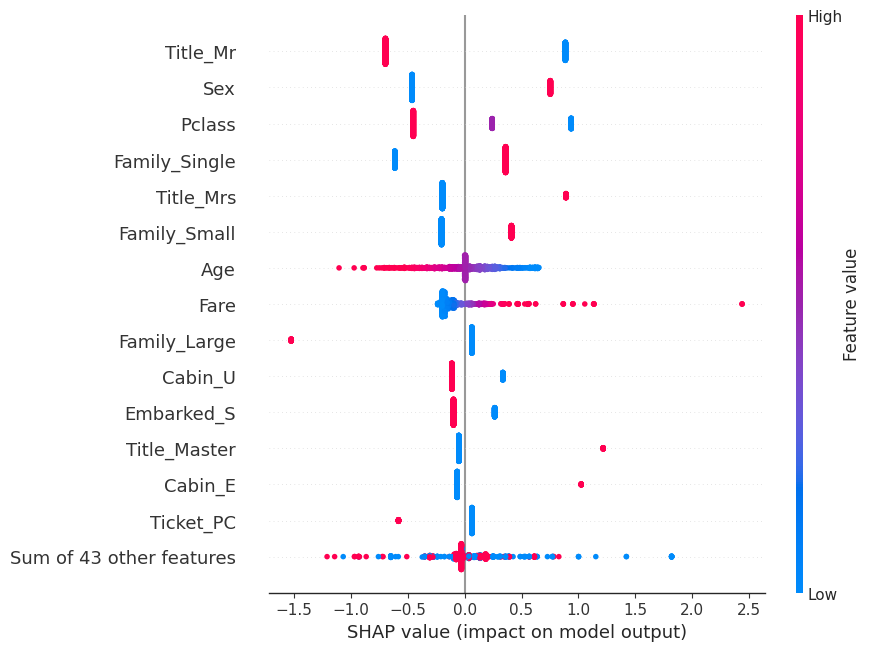

In [114]:
shap.plots.beeswarm(shap_values, max_display=15)

1、Title_Mr：對輸出結果影響平均0.77，稱謂使否是Mr對於生存機率的影響最大，稱謂是Mr時越不容易生存。

2、Sex：對輸出結果影響平均0.56，性別為男性時越不容易生存。

3、Pclass：對輸出結果影響平均0.52，艙等3較艙等1、2較不容易生存。

4、Family_Single：對輸出結果影響平均0.46，沒有父母或手足同行的人生存機率較高。

5、Title_Mrs：對輸出結果影響平均0.29，稱謂是Mrs時越容易生存。

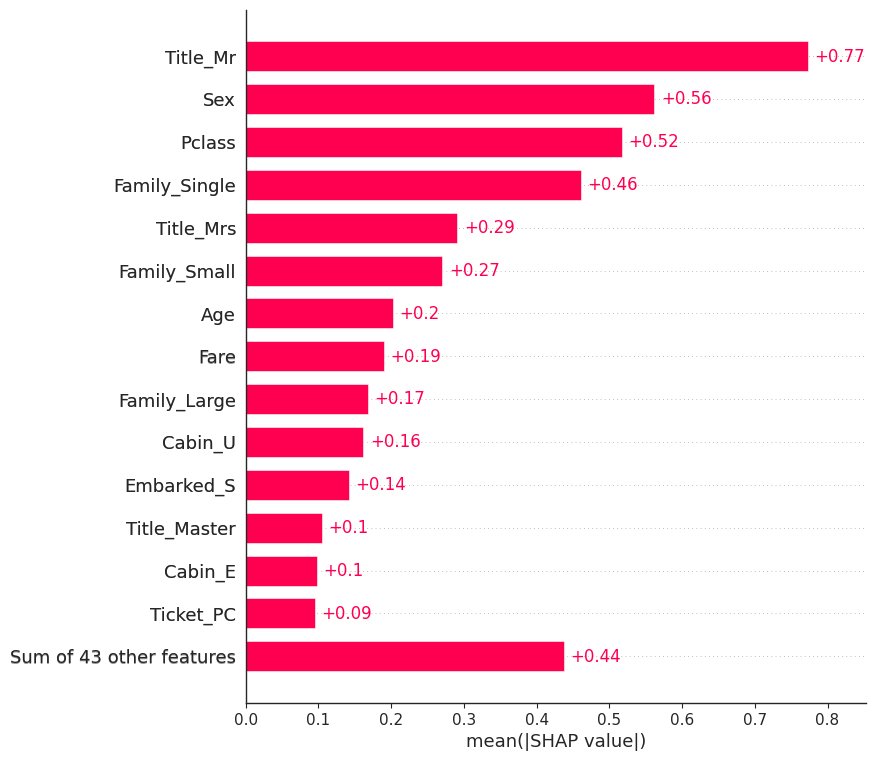

In [119]:
shap.plots.bar(shap_values.abs.mean(0), max_display=15)

▼▼▼所有稱謂對於輸出的影響▼▼▼

In [134]:
title_list = ["Title_Master", "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Officer", "Title_Royalty"]
title_values = {title: shap_values[:, title].abs.mean(0).values for title in title_list}
# shap_values[:, "Title_Master"].abs.mean(0).values

print(pd.DataFrame.from_dict(title_values, orient='index', columns=["abs_mean_SHAP_value"]).sort_values(by="abs_mean_SHAP_value", ascending=False))

               abs_mean_SHAP_value
Title_Mr                  0.773285
Title_Mrs                 0.290968
Title_Master              0.104791
Title_Officer             0.036279
Title_Miss                0.014430
Title_Royalty             0.000488


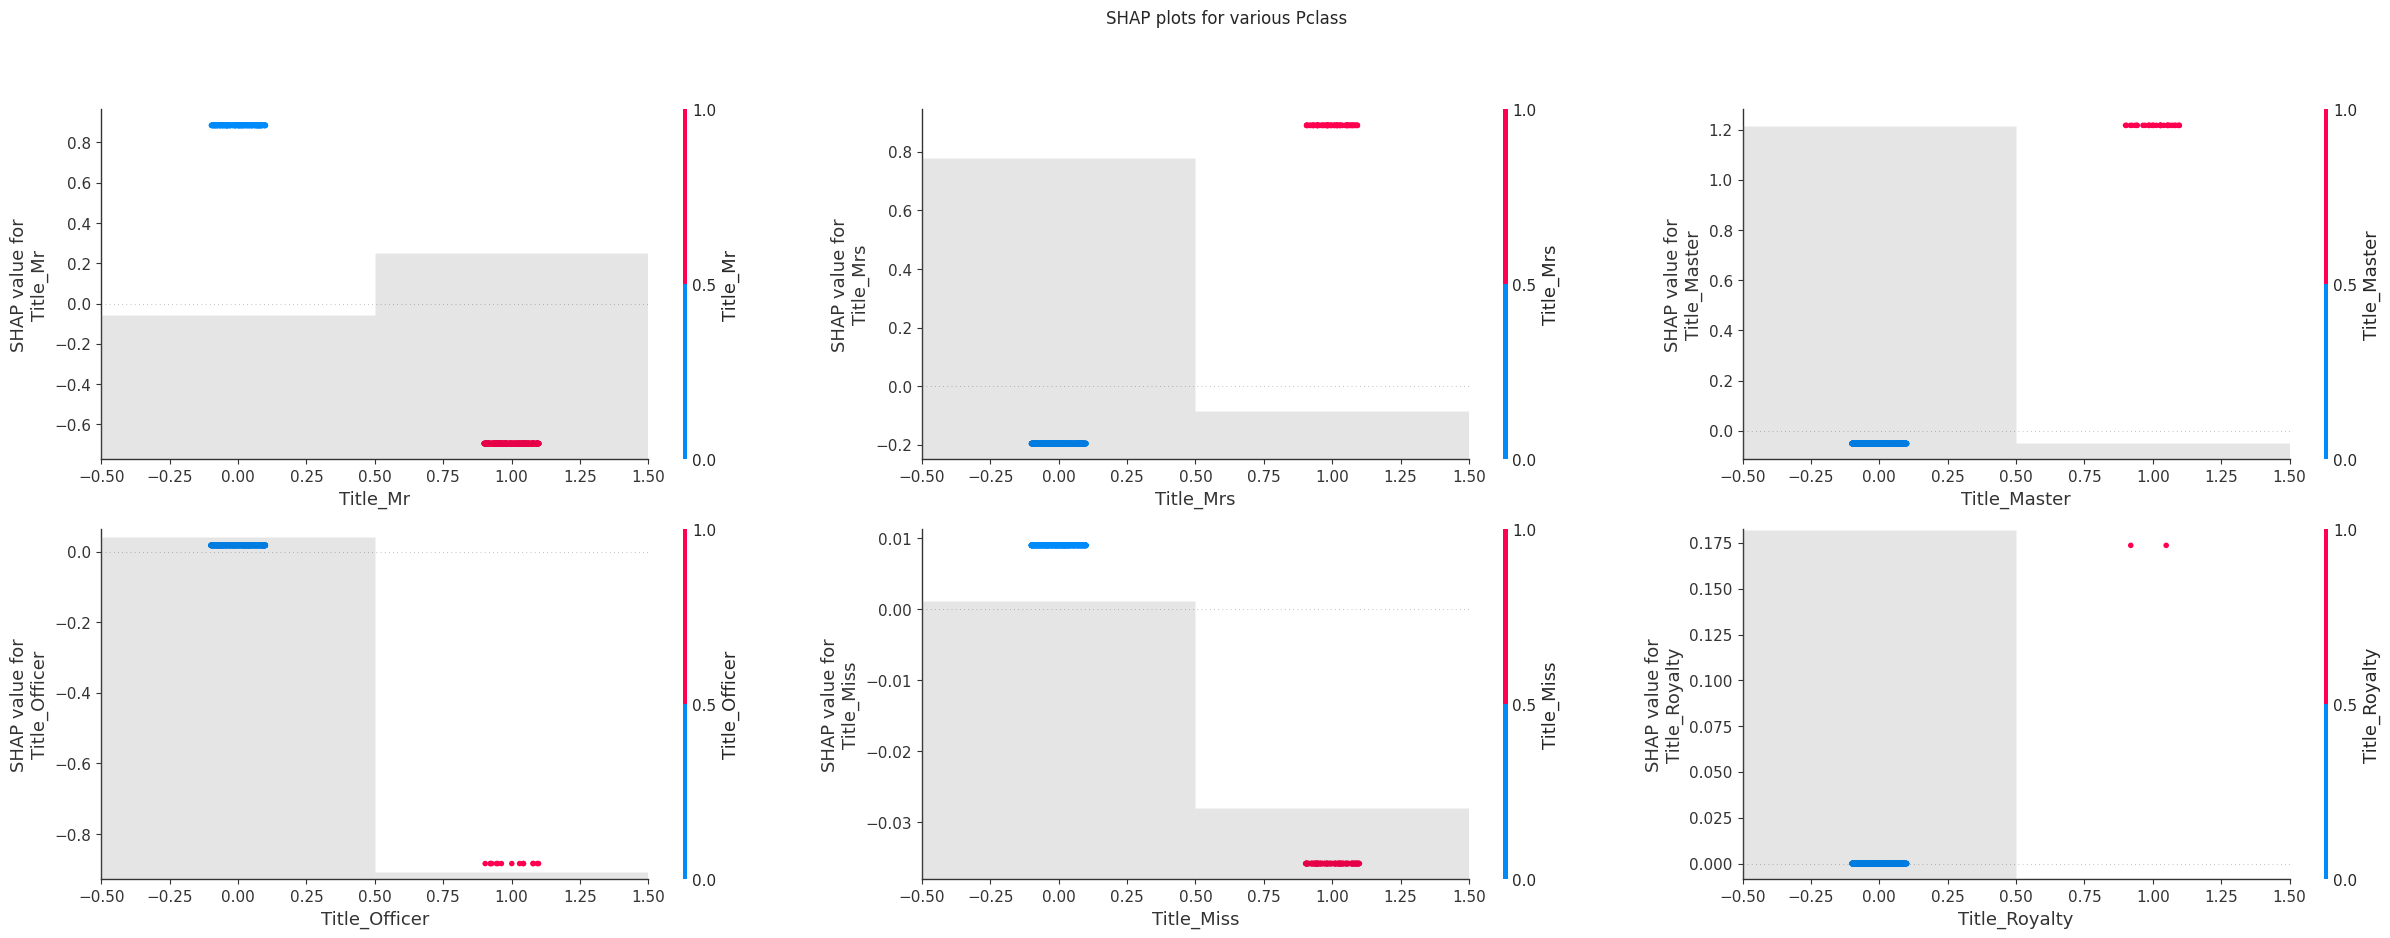

In [135]:
f, axes = plt.subplots(2,3, figsize=(30, 10))
f.suptitle("SHAP plots for various Pclass")

shap.plots.scatter(shap_values[:, "Title_Mr"], color=shap_values[:, "Title_Mr"], ax=axes[0, 0], show=False)
shap.plots.scatter(shap_values[:, "Title_Mrs"], color=shap_values[:, "Title_Mrs"], ax=axes[0, 1], show=False)
shap.plots.scatter(shap_values[:, "Title_Master"], color=shap_values[:, "Title_Master"], ax=axes[0, 2], show=False)
shap.plots.scatter(shap_values[:, "Title_Officer"], color=shap_values[:, "Title_Officer"], ax=axes[1, 0], show=False)
shap.plots.scatter(shap_values[:, "Title_Miss"], color=shap_values[:, "Title_Miss"], ax=axes[1, 1], show=False)
shap.plots.scatter(shap_values[:, "Title_Royalty"], color=shap_values[:, "Title_Royalty"], ax=axes[1, 2], show=False)

plt.show()

### Local interpretability

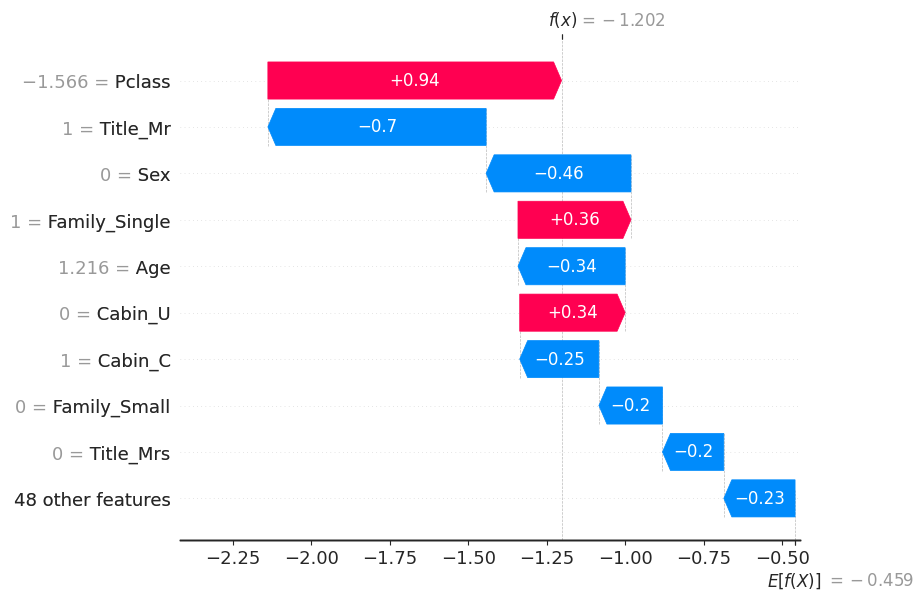

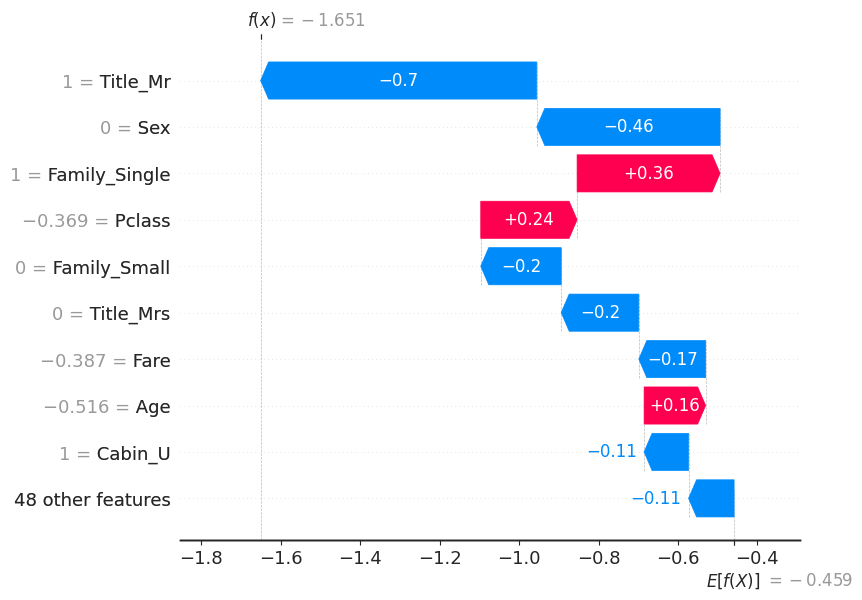

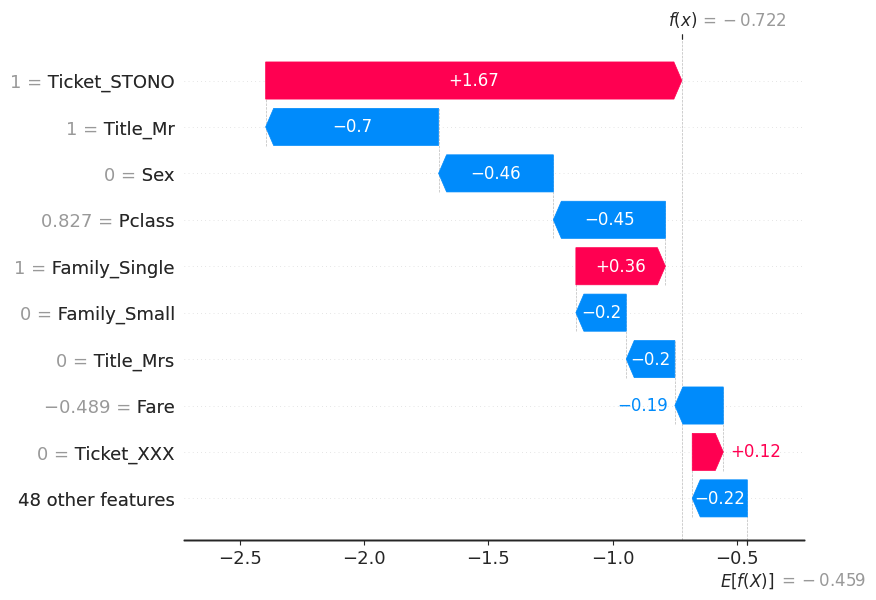

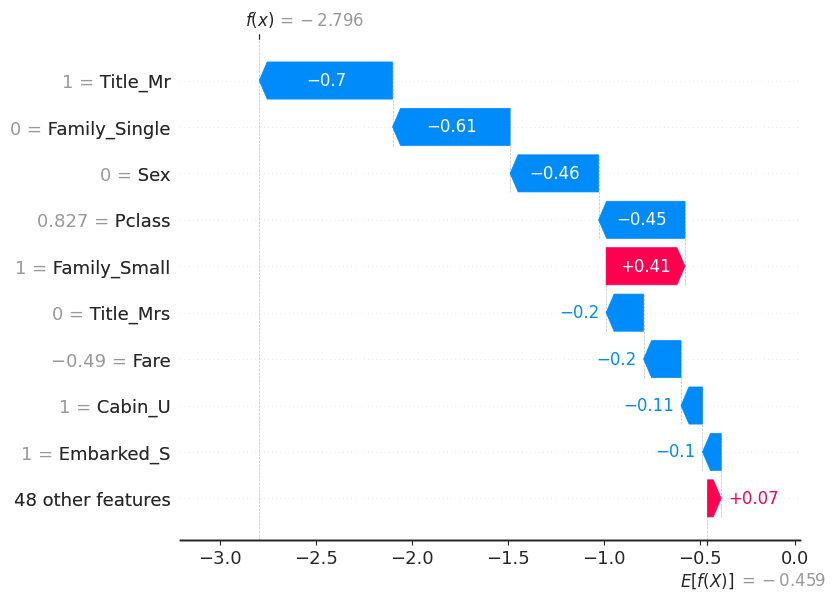

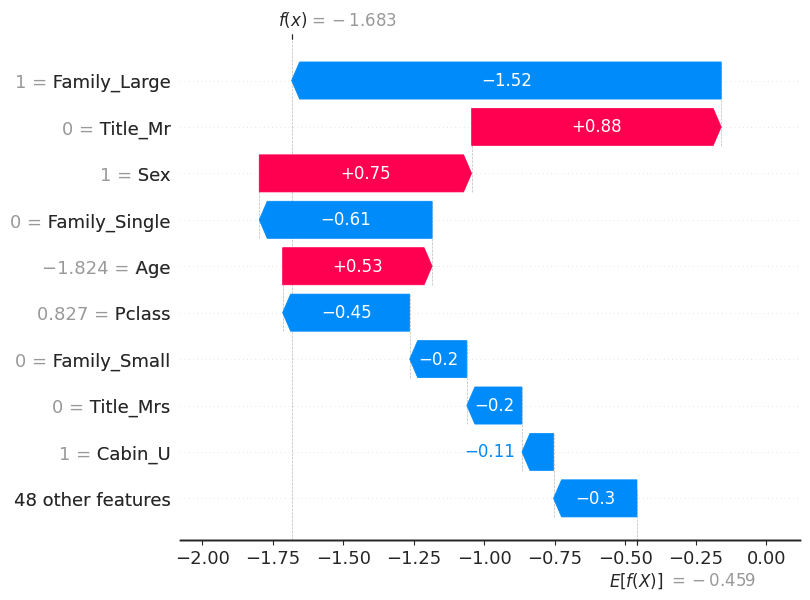

In [140]:
# 列出前5筆決策細節
for i in range(5):
  shap.plots.waterfall(shap_values[i])